In [1]:
import os
import glob
import shutil
import random
import itertools
import numpy as np
import tensorflow as tf
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator

In [2]:
path = os.getcwd()+'/data/dogsvscats' #used to get current directory
os.chdir(path)
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    

    for c in random.sample(glob.glob('train/cat*'),500):
        shutil.move(c,'train/cat')
    for c in random.sample(glob.glob('train/dog*'),500):
        shutil.move(c,'train/dog')
    for c in random.sample(glob.glob('train/cat*'),100):
        shutil.move(c,'valid/cat')
    for c in random.sample(glob.glob('train/dog*'),100):
        shutil.move(c,'valid/dog')
    for c in random.sample(glob.glob('train/cat*'),50):
        shutil.move(c,'test/cat')
    for c in random.sample(glob.glob('train/dog*'),50):
        shutil.move(c,'test/dog')

In [3]:
train_path = path + '/train'
valid_path = path + '/valid'
test_path = path + '/test'

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
.flow_from_directory(directory=train_path,target_size=(224,224),classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
.flow_from_directory(directory=test_path,target_size=(224,224),classes=['cat', 'dog'],shuffle=False, batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
.flow_from_directory(directory=valid_path,target_size=(224,224),classes=['cat', 'dog'], batch_size=10)

Found 1000 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [5]:
assert train_batches.n == 1000
assert test_batches.n == 100
assert valid_batches.n == 200
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes

In [6]:
# plots images with labels within jupyter notebook
def plotImages(images,labels):
    fig, axes = plt.subplots(2,5,figsize=(20,10))
    axes = axes.flatten()
    for img, ax, label in zip(images,axes,labels):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
imgs, labels = next(train_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

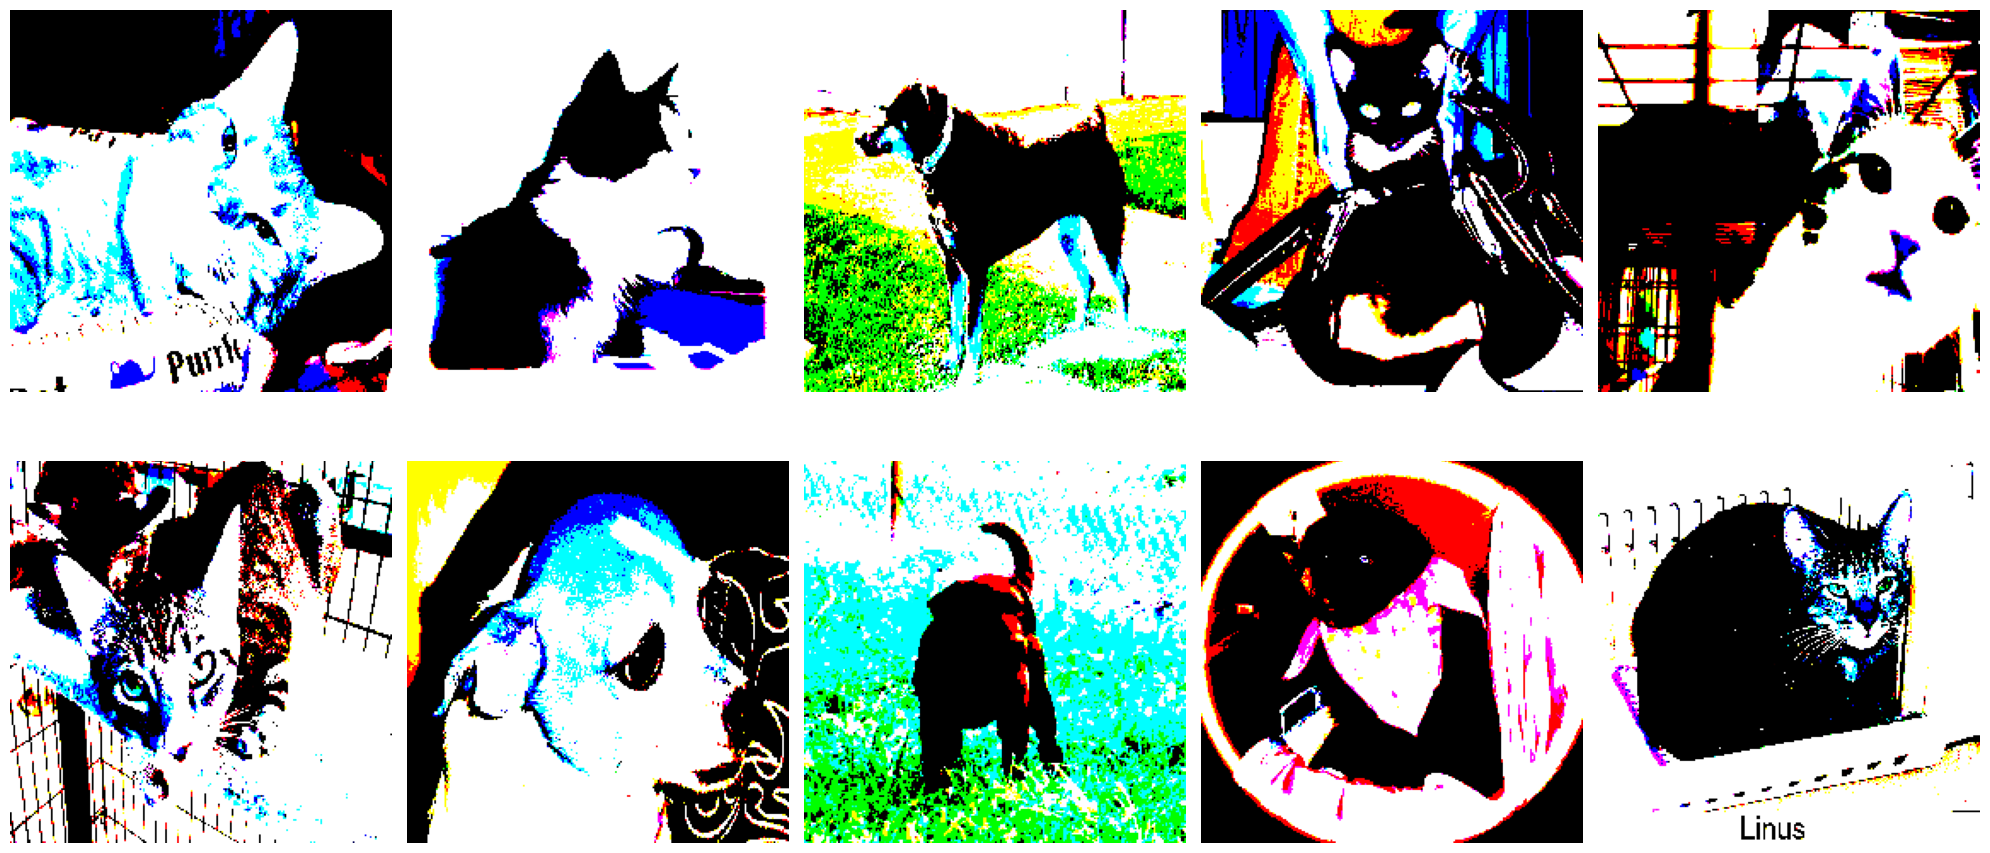

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [8]:
plotImages(imgs,labels)
print(labels)

#### Build Fine-tuned VGG16 model
It's the model that won 2014 ImageNet competition.
ImageNet is library of thousands of images belonging to 1000 classes

In [9]:
# internet connection needed about 500MB
vgg16_model = keras.applications.vgg16.VGG16()

In [10]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list())
                                    for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) 
                                    for v in model.trainable_weights])
    print(non_trainable_params,trainable_params)
    return {'non_trainable_params': non_trainable_params,'trainable_params': trainable_params}


In [12]:
params = count_params(vgg16_model)
assert params['non_trainable_params'] == 0
assert params['trainable_params'] == 138357544

0.0 138357544


In [13]:
type(vgg16_model)

keras.engine.functional.Functional

In [14]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [16]:
for layer in model.layers:
    layer.trainable = False

In [17]:
model.add(Dense(2, activation='softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [19]:
params = count_params(vgg16_model)
assert params['non_trainable_params'] == 134260544
assert params['trainable_params'] == 4097000

134260544 4097000


Training and Fine tuining VGG16 Model

In [20]:
model.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.fit(x=train_batches, validation_data=valid_batches,
          epochs=5, verbose=2)

Epoch 1/5
100/100 - 204s - loss: 0.3015 - accuracy: 0.8720 - val_loss: 0.1679 - val_accuracy: 0.9200 - 204s/epoch - 2s/step
Epoch 2/5
100/100 - 191s - loss: 0.0922 - accuracy: 0.9590 - val_loss: 0.1311 - val_accuracy: 0.9550 - 191s/epoch - 2s/step
Epoch 3/5
100/100 - 204s - loss: 0.0612 - accuracy: 0.9840 - val_loss: 0.1220 - val_accuracy: 0.9600 - 204s/epoch - 2s/step
Epoch 4/5
100/100 - 173s - loss: 0.0454 - accuracy: 0.9900 - val_loss: 0.1169 - val_accuracy: 0.9600 - 173s/epoch - 2s/step
Epoch 5/5
100/100 - 196s - loss: 0.0334 - accuracy: 0.9950 - val_loss: 0.1161 - val_accuracy: 0.9750 - 196s/epoch - 2s/step


<h4>Making Predictions  using fine tuned VGG16</h4>

In [22]:
predictions = model.predict(test_batches,verbose=0)

In [23]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [24]:
cm = confusion_matrix(y_true=test_batches.classes,y_pred = np.argmax(predictions, axis=-1))

In [25]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

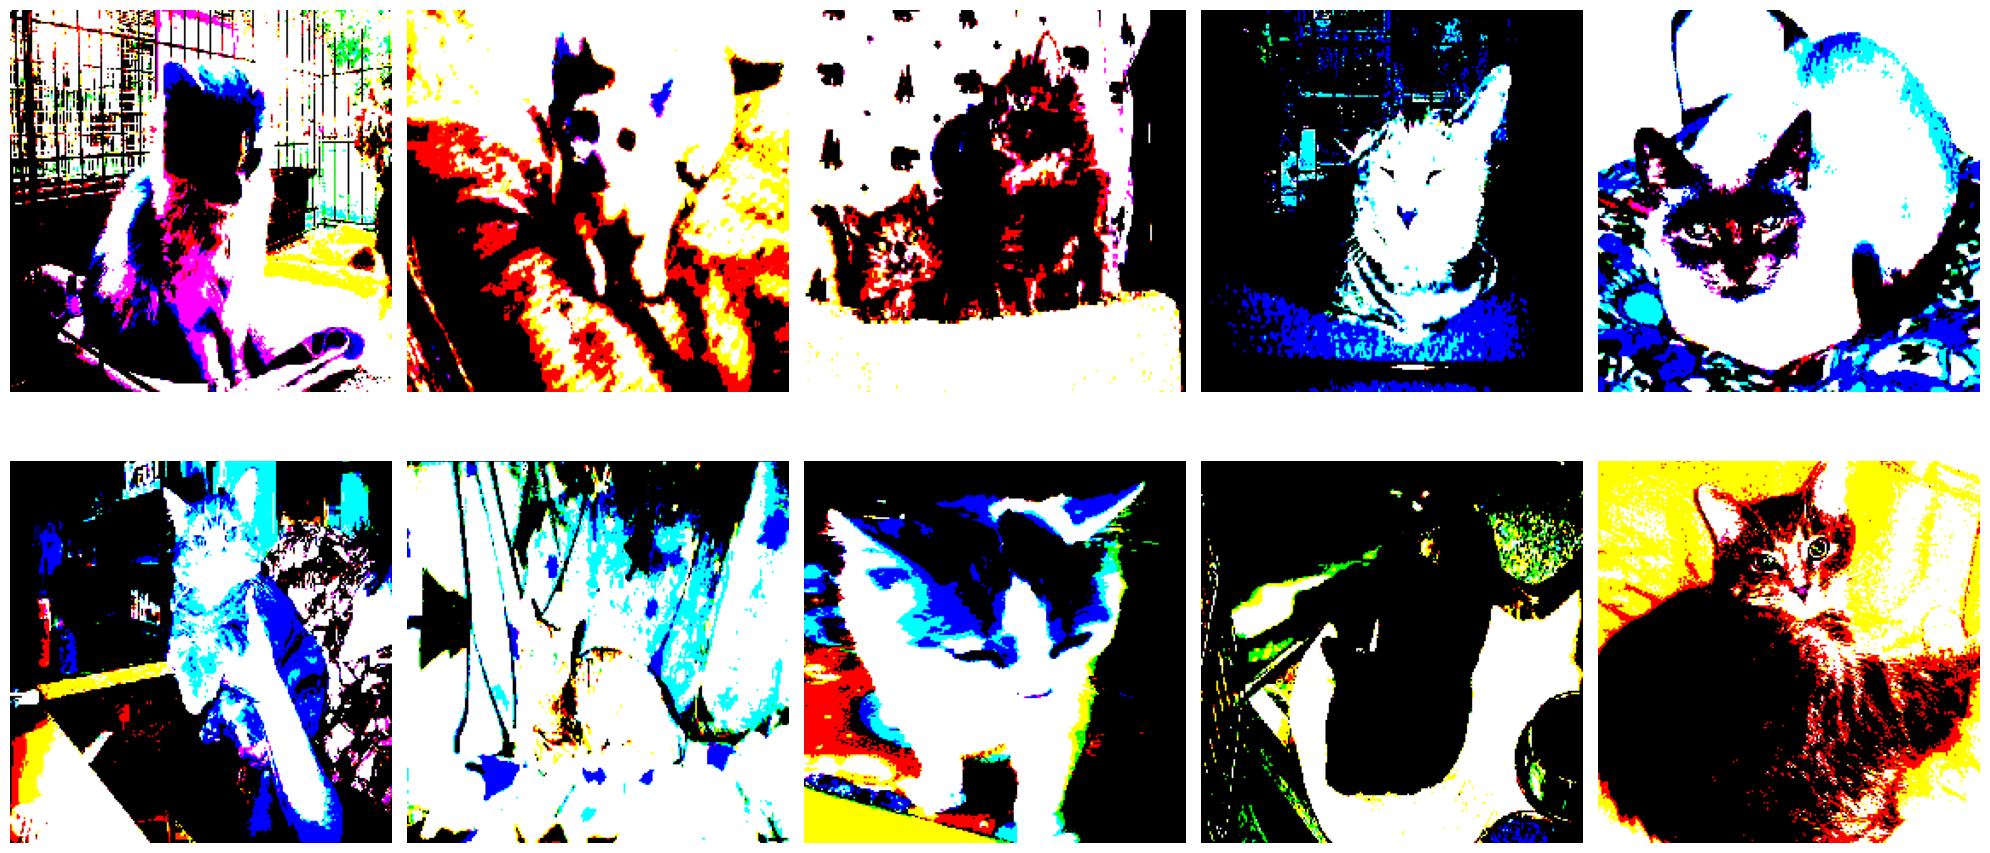

In [26]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs,test_labels)

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[50  0]
 [ 3 47]]


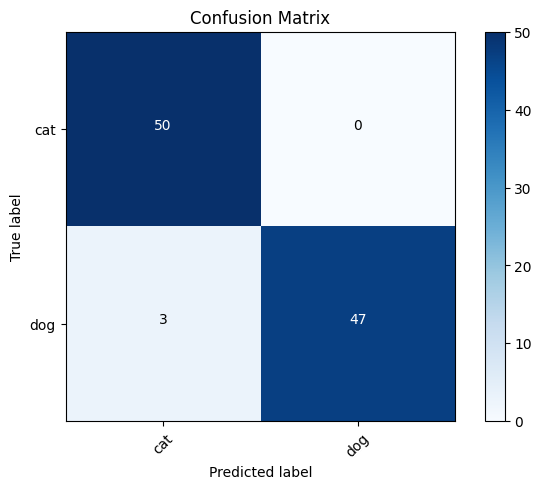

In [29]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix') 

Saving Model 

In [35]:
import os.path
#next line basically checks if model is already saved don't save it
if os.path.isfile('vgg16_catvsdog.h5') is False:
    model.save('vgg16catvsdog.h5')